# **Prevendo valores do Bitcoin entre dezembro de 2014 a maio de 2018 usando Redes LSTMs**

### Membros

* Antônio Barros
* André Vasconcelos
* Heitor Santos
* João Vítor Valadares
* Robson Oliveira

###Introdução
Esse relatório fala sobre o desenvolvimento de uma solução para o problema de predição do valor do Bitcoin baseado nos seus registros de dezembro de 2014 até maio de 2018, com a utilização de Redes Neurais Recorrentes LSTM. O dataset consiste de 1273 registros da cotação do Bitcoin, e em cada um dessas entradas, vamos ter 8 atributos que especificam eles.

##Bibliotecas

* Utilizamos para o treinamento e modelagem da  nossa Rede Neural, o conjunto de bibliotecas do Tensorflow e Keras. 
* O Numpy para representar dados e funções. 
* SkLearn para o processo de escalmento dos dados
(pré-processamento)
* Pandas para representação e manipulação de Dataframes
* MatPlot para a visualização gráfica dos dados. 
* Os para manipulação de arquivos do sistema

---



In [ ]:
import os
import io
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import SGD, Adam
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

%matplotlib inline

##Processando e Carregando Dado

Primeiro vamos importar o CSV correspondente ao problema e deixar pré-estabelecido o caminho para ele.


In [ ]:
if not os.path.exists("predicting-bitcoin-prices-using-LSTM/"):
  !git clone https://github.com/brynmwangy/predicting-bitcoin-prices-using-LSTM.git
if os.path.exists("predicting-bitcoin-prices-using-LSTM/btc.ipynb"):
  os.remove("predicting-bitcoin-prices-using-LSTM/btc.ipynb")

path_csv = "predicting-bitcoin-prices-using-LSTM/btc.csv"

Cloning into 'predicting-bitcoin-prices-using-LSTM'...
remote: Enumerating objects: 14, done.
remote: Total 14 (delta 0), reused 0 (delta 0), pack-reused 14
Unpacking objects: 100% (14/14), done.


Vamos utilizar a biblioteca do pandas para fazer a leitura/importação do nosso csv que contêm os registros de fechamanto da cotação do bitcoin para Dataframe, e em seguida inverter o dataset de acordo com a data, para dividir de acordo com a cronologia deles.



In [ ]:
btc = pd.read_csv(path_csv).sort_values(by="Date", key=pd.to_datetime)
btc.head()

,Date,Symbol,Open,High,Low,Close,Volume From,Volume To
1272,12/1/2014,BTCUSD,300.0,370.0,300.00,370.0,0.05656,19.53
1271,12/2/2014,BTCUSD,370.0,378.0,370.00,378.0,15.01000,5675.07
1270,12/3/2014,BTCUSD,378.0,378.0,377.01,378.0,0.54660,206.52
1269,12/4/2014,BTCUSD,378.0,378.0,377.10,377.1,0.01000,3.77
1268,12/5/2014,BTCUSD,377.1,377.1,377.10,377.1,0.00000,0.00


Vamos selecionar agora apenas a coluna do nosso Dataframe que vamos utilizar para o processo de predição.

In [ ]:
data_to_use=btc['Close'].values

print("Tamanho Coluna: {0}\n".format(len(data_to_use)))
print(data_to_use)

Tamanho Coluna: 1273

[ 370.    378.    378.   ... 7584.15 7459.11 7520.  ]


Nesse parte do código, vamos aplicar técnicas de pré-processamento de dados, como a de "Scaling", onde vamos dimensionar nossos dados de acordo com a média dos exemplos e seu desvio padrão (StandardScaler da bibliotecoa do SkLearn), dessa maneira vamos estar normalizando os valores para se tornar mais rápido o treinamento e a conversação da nossa rede neural, sem ser influeciada pela diferença de valores do nosso Dataframe. Em seguida vamos plotar com a biblioteca MatPlot esses nossos valores normalizados.

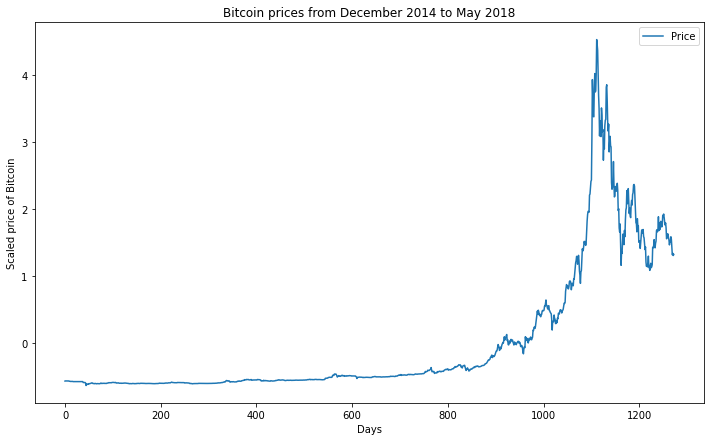

In [ ]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_to_use.reshape(-1, 1))

plt.figure(figsize=(12,7), frameon=False, facecolor='brown', edgecolor='blue')
plt.title('Bitcoin prices from December 2014 to May 2018')
plt.xlabel('Days')
plt.ylabel('Scaled price of Bitcoin')
plt.plot(scaled_data, label='Price')
plt.legend()
plt.show()



## Definindo Funções

*   **Window_data**: Essa função é responsável pela a divisão do dataset do projeto, de acordo com o *window_size*, que basicamente é quantos dados de entrada vão utilizar para prever o próximo dado em sequência.
*   **split_data**: Essa função é responsável pela a divisão do dataset do window_data, em vetores de treinamento e teste para utilizar no treinamento e avaliação do nosso teste.
* **plot**: Essa função é responsável por plotar o nosso gráfico que demonstra o desemepnho da nossa rede em dados de treinamento, testes e os valores reais

In [ ]:
def window_data(data, window_size):
    X = []
    y = []
    
    i = 0
    while (i + window_size) <= len(data) - 1:
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
        
        i += 1
    assert len(X) ==  len(y)
    return X, y

def split_data(X,y):

  train_split = 0.8
  length_data = len(X)
  lower_bound_data = int(train_split * length_data)

  X = np.array(X)
  y = np.array(y)

  X_train = X[:lower_bound_data]
  shape_x_train = X_train.shape
  X_train = X_train.reshape(shape_x_train[0],shape_x_train[2],shape_x_train[1])

  y_train = y[:lower_bound_data]
  shape_y_train = y_train.shape
  y_train = y_train.reshape(shape_y_train[0],shape_y_train[1],1)

  X_test = X[lower_bound_data:]
  shape_x_test = X_test.shape
  X_test = X_test.reshape(shape_x_test[0],shape_x_test[2],shape_x_test[1])

  y_test = y[lower_bound_data:]
  shape_y_test = y_test.shape
  y_test = y_test.reshape(shape_y_test[0],shape_y_test[1],1)

  return X_train, y_train, X_test, y_test

def plot(model, X_train, X_test):
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)

    test_results = []
    index = 0
    for i in range(len(X_train) + len(X_test)):
      if i >= len(X_train):
        test_results.append(test_pred[index])
        index += 1
      else:
        test_results.append(None)

    plt.figure(figsize=(15,7), frameon=False, facecolor='brown', edgecolor='blue')
    plt.title('Bitcoin prices from December 2014 to May 2018')
    plt.xlabel('Days')
    plt.ylabel('Scaled price of Bitcoin')
    plt.plot(scaled_data, label='Price')
    plt.plot(train_pred, label='Training Data')
    plt.plot(test_results, label='Testing Data')
    plt.legend()
    plt.show()


    


## Definindo Hiperparâmetros

Nessa parte do código definimos os hiperparâmetros usados para fazer o modelo da LSTM.



In [ ]:
batch_size = 7
window_size = 4
epochs = 200
activation_function = 'sigmoid'
optimizer = 'adam'
loss_function = 'mean_squared_error'

Aqui vamos separar o nossos dados que foram gerados pela função "window_data" em treinamento e teste, com 80% e 20% do tamanho deles respectivamente.

In [ ]:
X, y = window_data(scaled_data, window_size)

X_train, y_train, X_test, y_test = split_data(X,y)

print("X_train size: {}".format(X_train.shape))
print("y_train size: {}".format(y_train.shape))
print("X_test size: {}".format(X_test.shape))
print("y_test size: {}".format(y_test.shape))


X_train size: (1015, 1, 4)
y_train size: (1015, 1, 1)
X_test size: (254, 1, 4)
y_test size: (254, 1, 1)


## Primeira Versão LSTM

Primeiramente vamos definir a nossa primeira versão da rede neural LSTM, baseado inicialmente nos parâmetros que foram dados no projeto. Utilizando uma camada LSTM com 4 unidades (dimensão do estado saída) uma função de ativação sigmoide para cada célula da nossa camada, e uma camada de saída com um neurônio.

In [ ]:
model1 = keras.Sequential([
    layers.LSTM(4, activation = activation_function, input_shape=(1, window_size)),
    layers.Dense(1)
])

model1.compile(loss=loss_function, optimizer=optimizer)
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 4)                 144       
                                                                 
 dense (Dense)               (None, 1)                 5         
                                                                 
Total params: 149
Trainable params: 149
Non-trainable params: 0
_________________________________________________________________


In [ ]:
training_1=model1.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)

Epoch 1/200
145/145 [==============================] - 2s 2ms/step - loss: 0.6439
Epoch 2/200
145/145 [==============================] - 0s 2ms/step - loss: 0.2845
Epoch 3/200
145/145 [==============================] - 0s 2ms/step - loss: 0.1231
Epoch 4/200
145/145 [==============================] - 0s 2ms/step - loss: 0.0533
Epoch 5/200
145/145 [==============================] - 0s 2ms/step - loss: 0.0327
Epoch 6/200
145/145 [==============================] - 0s 2ms/step - loss: 0.0273
Epoch 7/200
145/145 [==============================] - 0s 2ms/step - loss: 0.0242
Epoch 8/200
145/145 [==============================] - 0s 2ms/step - loss: 0.0214
Epoch 9/200
145/145 [==============================] - 0s 2ms/step - loss: 0.0185
Epoch 10/200
145/145 [==============================] - 0s 2ms/step - loss: 0.0158
Epoch 11/200
145/145 [==============================] - 0s 2ms/step - loss: 0.0132
Epoch 12/200
145/145 [==============================] - 0s 2ms/step - loss: 0.0108
Epoch 13/200


O modelo apresentou uma ótima semalhance no inicio, na parte que se assemelha a parte de treinamento, porém quando começamos a analisar os dados de teste, quanto mais dias se passam mais a nossas predições deixam de se assemalhar com o verdadeiro valor. Mostrando sinais de overfitting de dados. E um alto valor de erro.

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


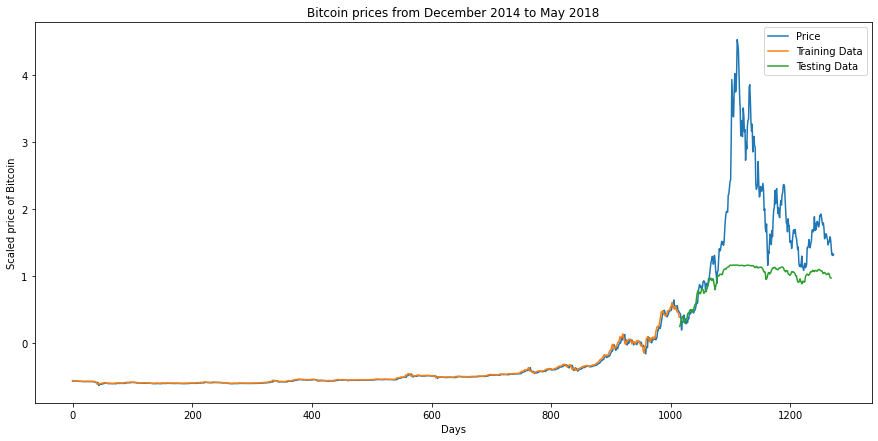

8/8 [==============================] - 0s 3ms/step - loss: 1.2168


1.216835379600525

In [ ]:
plot(model1,X_train,X_test)
model1.evaluate(X_test,y_test)

## Segunda Versão LSTM

Para o segundo teste, vamos aumentar o número de neurônios da nossa camada de input da LSTM. De 4 para 256.





In [ ]:
model2 = keras.Sequential([
    layers.LSTM(256, activation = activation_function, input_shape=(1, window_size)),
    layers.Dense(1)
])

model2.compile(loss=loss_function, optimizer=optimizer)
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 256)               267264    
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 267,521
Trainable params: 267,521
Non-trainable params: 0
_________________________________________________________________


In [ ]:
training_2=model2.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)

Epoch 1/200
145/145 [==============================] - 2s 5ms/step - loss: 0.0148
Epoch 2/200
145/145 [==============================] - 1s 5ms/step - loss: 4.7697e-04
Epoch 3/200
145/145 [==============================] - 1s 5ms/step - loss: 4.7764e-04
Epoch 4/200
145/145 [==============================] - 1s 5ms/step - loss: 4.6289e-04
Epoch 5/200
145/145 [==============================] - 1s 5ms/step - loss: 4.9660e-04
Epoch 6/200
145/145 [==============================] - 1s 5ms/step - loss: 4.6773e-04
Epoch 7/200
145/145 [==============================] - 1s 5ms/step - loss: 5.3888e-04
Epoch 8/200
145/145 [==============================] - 1s 5ms/step - loss: 5.4354e-04
Epoch 9/200
145/145 [==============================] - 1s 5ms/step - loss: 6.5125e-04
Epoch 10/200
145/145 [==============================] - 1s 5ms/step - loss: 4.8457e-04
Epoch 11/200
145/145 [==============================] - 1s 5ms/step - loss: 5.4304e-04
Epoch 12/200
145/145 [==============================] - 

Apenas aumentando o número de neurônios da nossa camada LSTM, percebemos que os valores de teste que não estavam convergindo, melhoraram significativamente, a nossa rede conseguiu desempenhar muito bem com o aumento de neurônios, além do erro diminuir consideravelmente.

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


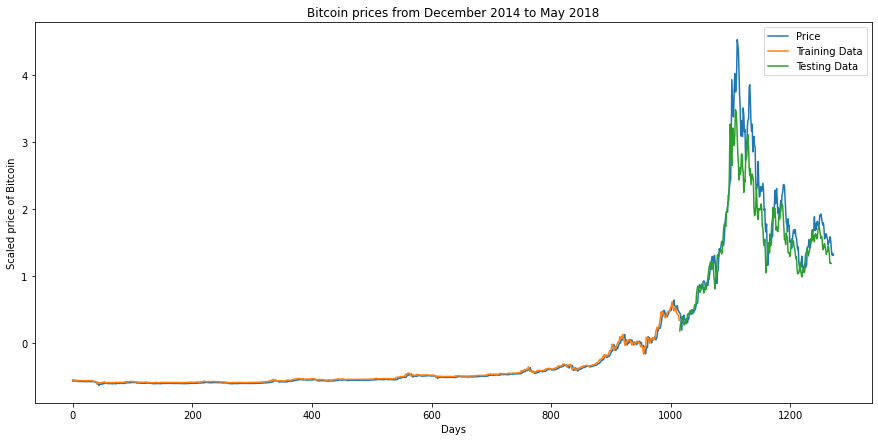

8/8 [==============================] - 0s 3ms/step - loss: 0.1194


0.11937033385038376

In [ ]:
plot(model2,X_train,X_test)
model2.evaluate(X_test,y_test)

## Terceira Versão LSTM

Para nosso terceiro experimento, utilizando nosso melhor modelo até o momento (versão 2) vamos adicionar uma taxa de droupt razóavel na nossa camada de input da LSTM





In [ ]:
model3 = keras.Sequential([
    layers.LSTM(256, dropout=0.3, activation = activation_function, input_shape=(1, window_size)),
    layers.Dense(1)
])

model3.compile(loss=loss_function, optimizer=optimizer)
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 256)               267264    
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
Total params: 267,521
Trainable params: 267,521
Non-trainable params: 0
_________________________________________________________________


In [ ]:
training_3=model3.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)

Epoch 1/200
145/145 [==============================] - 2s 5ms/step - loss: 0.0311
Epoch 2/200
145/145 [==============================] - 1s 6ms/step - loss: 0.0203
Epoch 3/200
145/145 [==============================] - 1s 5ms/step - loss: 0.0212
Epoch 4/200
145/145 [==============================] - 1s 6ms/step - loss: 0.0224
Epoch 5/200
145/145 [==============================] - 1s 6ms/step - loss: 0.0206
Epoch 6/200
145/145 [==============================] - 1s 6ms/step - loss: 0.0192
Epoch 7/200
145/145 [==============================] - 1s 6ms/step - loss: 0.0196
Epoch 8/200
145/145 [==============================] - 1s 6ms/step - loss: 0.0189
Epoch 9/200
145/145 [==============================] - 1s 6ms/step - loss: 0.0198
Epoch 10/200
145/145 [==============================] - 1s 6ms/step - loss: 0.0190
Epoch 11/200
145/145 [==============================] - 1s 6ms/step - loss: 0.0181
Epoch 12/200
145/145 [==============================] - 1s 5ms/step - loss: 0.0205
Epoch 13/200


Adicionar dropout na nossa camada de LSTM não foi bem sucedido no experimento, provalvemente alguma informação do dataset está sendo perdida e isso influecia principalmente em um grande intervalo dos dados de treinamento e inconsistências nos dados de testes. Sendo assim temos uma piora tanto na acurácia do dados, quanto no erro.

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


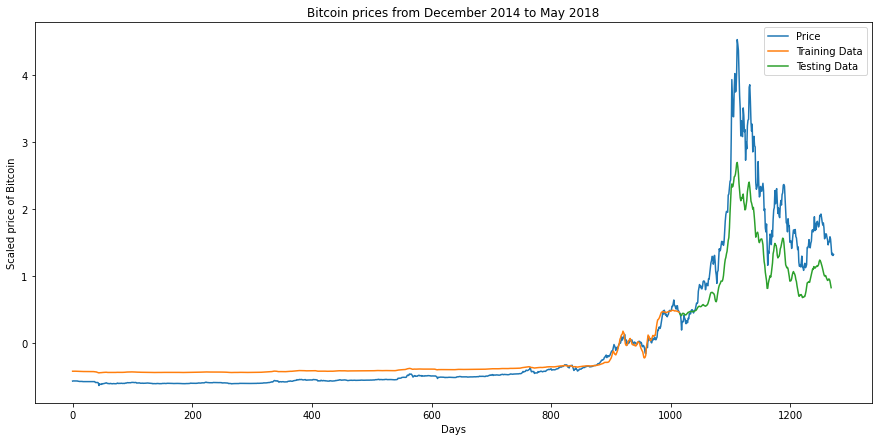

8/8 [==============================] - 0s 4ms/step - loss: 0.5277


0.5277212262153625

In [ ]:
plot(model3,X_train,X_test)
model3.evaluate(X_test,y_test)

## Quarta Versão LSTM

Nessa versão vamos aplicar técnicas de regularização L2 (função baseada na nossa função de erro) de pesos, no nosso melhor modelo (versão 2).





In [ ]:
model4 = keras.Sequential([
    layers.LSTM(256, activation = activation_function, input_shape=(1, window_size), recurrent_regularizer=tf.keras.regularizers.l2(l=0.001),kernel_regularizer=tf.keras.regularizers.l2(l=0.001),bias_regularizer=tf.keras.regularizers.l2(l=0.001)),
    layers.Dense(1)
])

model4.compile(loss=loss_function, optimizer=optimizer)
model4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 256)               267264    
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 267,521
Trainable params: 267,521
Non-trainable params: 0
_________________________________________________________________


In [ ]:
training_4=model4.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)

Epoch 1/200
145/145 [==============================] - 2s 6ms/step - loss: 0.2859
Epoch 2/200
145/145 [==============================] - 1s 6ms/step - loss: 0.1698
Epoch 3/200
145/145 [==============================] - 1s 6ms/step - loss: 0.1214
Epoch 4/200
145/145 [==============================] - 1s 6ms/step - loss: 0.0853
Epoch 5/200
145/145 [==============================] - 1s 6ms/step - loss: 0.0586
Epoch 6/200
145/145 [==============================] - 1s 6ms/step - loss: 0.0395
Epoch 7/200
145/145 [==============================] - 1s 6ms/step - loss: 0.0261
Epoch 8/200
145/145 [==============================] - 1s 6ms/step - loss: 0.0172
Epoch 9/200
145/145 [==============================] - 1s 6ms/step - loss: 0.0116
Epoch 10/200
145/145 [==============================] - 1s 6ms/step - loss: 0.0082
Epoch 11/200
145/145 [==============================] - 1s 6ms/step - loss: 0.0060
Epoch 12/200
145/145 [==============================] - 1s 6ms/step - loss: 0.0050
Epoch 13/200


Com a regularzição de pesos implementanda, obtemos uma grande melhora em relação a classe de teste e consequentemente, a diminuição do erro associado. E também é interessante notar que na classe de treinamento ele teve dificuldade de prever no inicio, provalvemente por causa da regularzição, que tem o intuito de diminuir o overfitting da nossa rede.

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


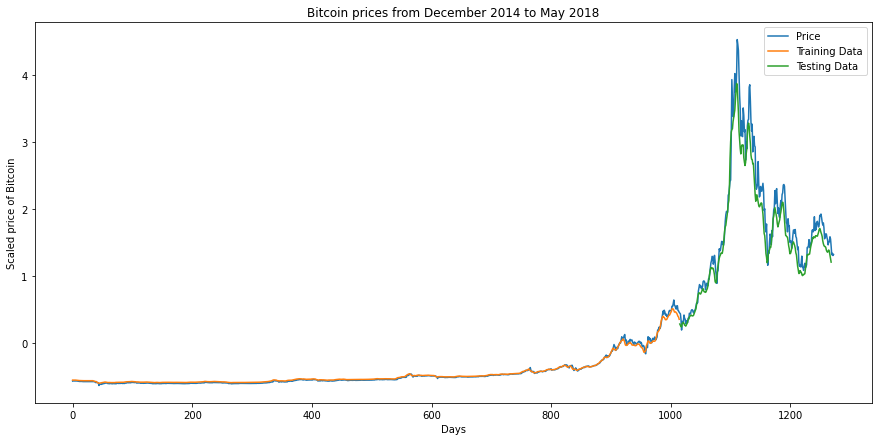

8/8 [==============================] - 0s 4ms/step - loss: 0.0876


0.08757714927196503

In [ ]:
plot(model4,X_train,X_test)
model4.evaluate(X_test,y_test)

## Quinta Versão LSTM

Nessa versão vamos aumentar o "window_size" dos nossos dados.




In [ ]:
window_size = 11

X, y = window_data(scaled_data, window_size)

X_train, y_train, X_test, y_test = split_data(X,y)

print("X_train size: {}".format(X_train.shape))
print("y_train size: {}".format(y_train.shape))
print("X_test size: {}".format(X_test.shape))
print("y_test size: {}".format(y_test.shape))

X_train size: (1009, 1, 11)
y_train size: (1009, 1, 1)
X_test size: (253, 1, 11)
y_test size: (253, 1, 1)


In [ ]:
model5 = keras.Sequential([
    layers.LSTM(256, activation = activation_function, input_shape=(1, window_size), recurrent_regularizer=tf.keras.regularizers.l2(l=0.001),kernel_regularizer=tf.keras.regularizers.l2(l=0.001),bias_regularizer=tf.keras.regularizers.l2(l=0.001)),
    layers.Dense(1)
])

model5.compile(loss=loss_function, optimizer=optimizer)
model5.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 256)               274432    
                                                                 
 dense_9 (Dense)             (None, 1)                 257       
                                                                 
Total params: 274,689
Trainable params: 274,689
Non-trainable params: 0
_________________________________________________________________


In [ ]:
training_5=model5.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)

Epoch 1/200
145/145 [==============================] - 2s 7ms/step - loss: 0.2828
Epoch 2/200
145/145 [==============================] - 1s 7ms/step - loss: 0.1676
Epoch 3/200
145/145 [==============================] - 1s 8ms/step - loss: 0.1192
Epoch 4/200
145/145 [==============================] - 1s 7ms/step - loss: 0.0830
Epoch 5/200
145/145 [==============================] - 1s 7ms/step - loss: 0.0563
Epoch 6/200
145/145 [==============================] - 1s 7ms/step - loss: 0.0373
Epoch 7/200
145/145 [==============================] - 1s 7ms/step - loss: 0.0241
Epoch 8/200
145/145 [==============================] - 1s 7ms/step - loss: 0.0154
Epoch 9/200
145/145 [==============================] - 1s 7ms/step - loss: 0.0099
Epoch 10/200
145/145 [==============================] - 1s 7ms/step - loss: 0.0068
Epoch 11/200
145/145 [==============================] - 1s 7ms/step - loss: 0.0047
Epoch 12/200
145/145 [==============================] - 1s 7ms/step - loss: 0.0038
Epoch 13/200


Ao aumentar a janela, pioramos o desempenho da nossa rede.

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


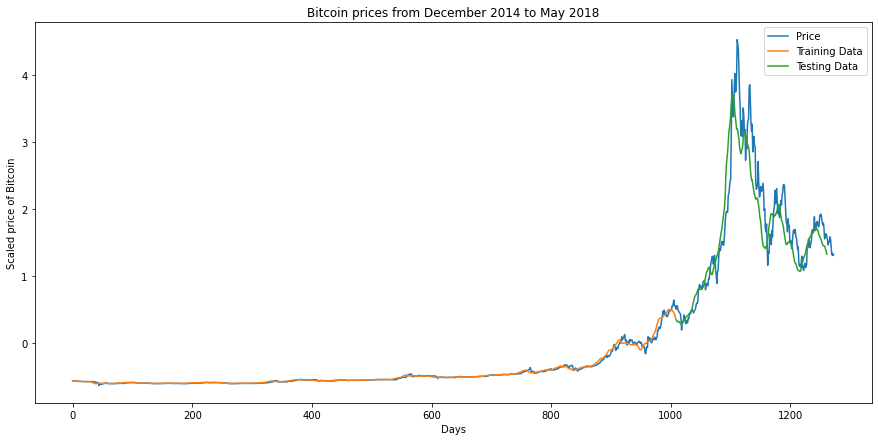

8/8 [==============================] - 0s 4ms/step - loss: 0.1012


0.10115231573581696

In [ ]:
plot(model5,X_train,X_test)
model5.evaluate(X_test,y_test)

## Sexta Versão LSTM

Nessa versão vamos diminuir o "window_size" dos nossos dados (de acordo com a nossa melhor versão que é a quarta).




In [ ]:
window_size = 3

X, y = window_data(scaled_data, window_size)

X_train, y_train, X_test, y_test = split_data(X,y)

print("X_train size: {}".format(X_train.shape))
print("y_train size: {}".format(y_train.shape))
print("X_test size: {}".format(X_test.shape))
print("y_test size: {}".format(y_test.shape))

X_train size: (1016, 1, 3)
y_train size: (1016, 1, 1)
X_test size: (254, 1, 3)
y_test size: (254, 1, 1)


In [ ]:
model6 = keras.Sequential([
    layers.LSTM(256, activation = activation_function, input_shape=(1, window_size), recurrent_regularizer=tf.keras.regularizers.l2(l=0.001),kernel_regularizer=tf.keras.regularizers.l2(l=0.001),bias_regularizer=tf.keras.regularizers.l2(l=0.001)),
    layers.Dense(1)
])

model6.compile(loss=loss_function, optimizer=optimizer)
model6.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 256)               266240    
                                                                 
 dense_7 (Dense)             (None, 1)                 257       
                                                                 
Total params: 266,497
Trainable params: 266,497
Non-trainable params: 0
_________________________________________________________________


In [ ]:
training_6=model6.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)

Epoch 1/200
146/146 [==============================] - 3s 8ms/step - loss: 0.3063
Epoch 2/200
146/146 [==============================] - 1s 8ms/step - loss: 0.1737
Epoch 3/200
146/146 [==============================] - 1s 8ms/step - loss: 0.1226
Epoch 4/200
146/146 [==============================] - 1s 8ms/step - loss: 0.0860
Epoch 5/200
146/146 [==============================] - 1s 8ms/step - loss: 0.0592
Epoch 6/200
146/146 [==============================] - 1s 8ms/step - loss: 0.0401
Epoch 7/200
146/146 [==============================] - 1s 8ms/step - loss: 0.0268
Epoch 8/200
146/146 [==============================] - 1s 8ms/step - loss: 0.0180
Epoch 9/200
146/146 [==============================] - 1s 8ms/step - loss: 0.0124
Epoch 10/200
146/146 [==============================] - 1s 8ms/step - loss: 0.0091
Epoch 11/200
146/146 [==============================] - 1s 8ms/step - loss: 0.0072
Epoch 12/200
146/146 [==============================] - 1s 8ms/step - loss: 0.0059
Epoch 13/200


Ao diminuir o tamanho da janela dos nossos dados, conseguirmos uma melhora no gráfico e nossos dados, tanto os de treinamento, quanto no teste. E consequentemente uma diminuição no erro.

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


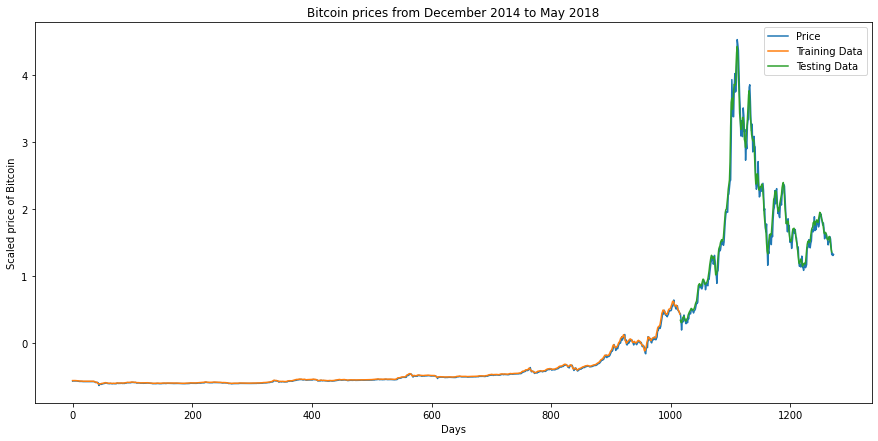

8/8 [==============================] - 0s 5ms/step - loss: 0.0422


0.04219547659158707

In [ ]:
plot(model6,X_train,X_test)
model6.evaluate(X_test,y_test)

## Sétima Versão LSTM

Utilizando o mesmo "window_size" do modelo passado, já que ele foi o nosso melhor, vamos aplicar aqui o "Early Stopping", para quando nossa "loss" piora 10 vezes, em relação aos seus valores passados.




In [ ]:
model7 = keras.Sequential([
    layers.LSTM(256, activation = activation_function, input_shape=(1, window_size), recurrent_regularizer=tf.keras.regularizers.l2(l=0.001),kernel_regularizer=tf.keras.regularizers.l2(l=0.001),bias_regularizer=tf.keras.regularizers.l2(l=0.001)),
    layers.Dense(1)
])

model7.compile(loss=loss_function, optimizer=optimizer)
model7.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 256)               266240    
                                                                 
 dense_8 (Dense)             (None, 1)                 257       
                                                                 
Total params: 266,497
Trainable params: 266,497
Non-trainable params: 0
_________________________________________________________________


In [ ]:
early_stopping = keras.callbacks.EarlyStopping(monitor="loss",patience=10)
training_7=model7.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, callbacks=[early_stopping])

Epoch 1/200
146/146 [==============================] - 2s 7ms/step - loss: 0.2858
Epoch 2/200
146/146 [==============================] - 1s 7ms/step - loss: 0.1706
Epoch 3/200
146/146 [==============================] - 1s 7ms/step - loss: 0.1217
Epoch 4/200
146/146 [==============================] - 1s 7ms/step - loss: 0.0854
Epoch 5/200
146/146 [==============================] - 1s 7ms/step - loss: 0.0587
Epoch 6/200
146/146 [==============================] - 1s 7ms/step - loss: 0.0396
Epoch 7/200
146/146 [==============================] - 1s 8ms/step - loss: 0.0263
Epoch 8/200
146/146 [==============================] - 1s 7ms/step - loss: 0.0176
Epoch 9/200
146/146 [==============================] - 1s 7ms/step - loss: 0.0119
Epoch 10/200
146/146 [==============================] - 1s 7ms/step - loss: 0.0085
Epoch 11/200
146/146 [==============================] - 1s 7ms/step - loss: 0.0065
Epoch 12/200
146/146 [==============================] - 1s 7ms/step - loss: 0.0056
Epoch 13/200


Com o Early Stopping o treinamento terminou na época 122 de 200, ou seja, nessa época que obtemos a 10 piora da "loss" e foi interrompido o processo. Com essa técnica não melhorou significativamente nosso modelo, porém tanto a loss quanto a curva ficaram bem parecidos com a do nosso modelo passado (que é a melhor versão ainda por muito pouco).

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


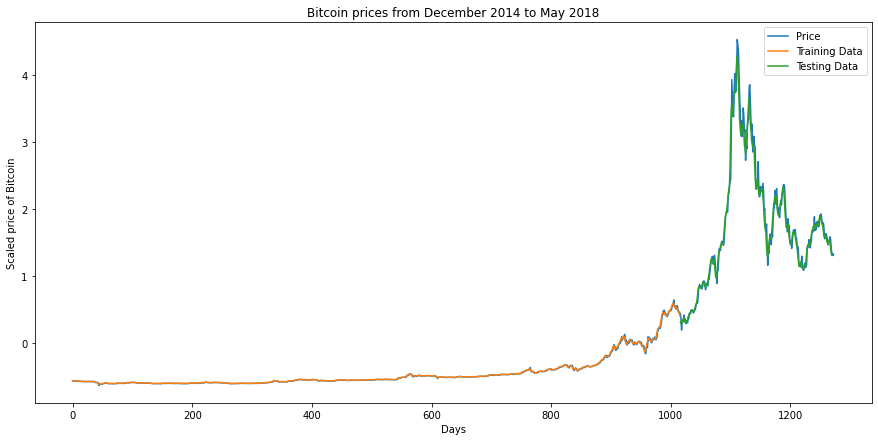

8/8 [==============================] - 0s 4ms/step - loss: 0.0426


0.04256616160273552

In [ ]:
plot(model7,X_train,X_test)
model7.evaluate(X_test,y_test)